In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import torch
import torch.autograd as autograd
import torch.optim as optim

from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm, trange

subsample_training_data = True
if subsample_training_data:
    from subsample import subsample

In [2]:
load_weights = True

In [3]:
plt.rc("axes",
    axisbelow = True,
    labelsize = 18,
    titlesize = 20
)
plt.rc("font", family = "serif")
plt.rc("image", cmap = "viridis")
plt.rc("legend",
    edgecolor = "k",
    fontsize = 15,
    framealpha = 1.0
)
plt.rc("text", usetex = True)
plt.rc("xtick", labelsize = 12)
plt.rc("ytick", labelsize = 12)

In [4]:
def tensor2array(t):
    return t.detach().cpu().numpy()

def vector_cosine(u, v):
    norm_u = torch.linalg.vector_norm(u, dim = 1)
    norm_v = torch.linalg.vector_norm(v, dim = 1)
    
    dot_product = torch.mul(u, v).sum(dim = 1)
    
    return dot_product/(norm_u*norm_v)

input_names = [
    r"$\theta_{10}$",
    r"$\theta_{12}$",
    r"$\theta_{20}$",
    r"$\theta_{21}$"
]

phi_idx = [1, 5, 11]
torch.set_default_dtype(torch.float64)

start_time = datetime.now()
print(start_time)

2022-08-02 11:43:44.480639


# Load and Preprocess Data

In [5]:
df_train = pd.read_excel("Simulation_and_DMaps.xlsx")
rawX_train = df_train[[c for c in df_train.columns if c[0] == "q"]].values
rawY_train = df_train[[c for c in df_train.columns if c[0] == "y"]].values
raw_phi_train = df_train[["p%d" % i for i in phi_idx]].values
raw_beta_train = df_train[[c for c in df_train.columns if c[0] == "b"]].values

In [6]:
df_test = pd.read_excel("Simulation_and_DMaps_Test_Data.xlsx")
rawX_test = df_test[[c for c in df_test.columns if c[0] == "q"]].values
rawY_test = df_test[[c for c in df_test.columns if c[0] == "y"]].values
raw_phi_test = df_test[["p%d" % i for i in phi_idx]].values
raw_beta_test = df_test[[c for c in df_test.columns if c[0] == "b"]].values

In [7]:
if subsample_training_data:
    (raw_phi_train, idx) = subsample(raw_phi_train, min_distance = 0.004, random_state = 77)
    rawX_train = rawX_train[idx]
    rawY_train = rawY_train[idx]
    raw_beta_train = raw_beta_train[idx]

Subsampling points.
Considering min_distance 0.004000.
Subsampling complete, taking 1134 out of 5000 points.


In [8]:
X_scaler = MinMaxScaler(feature_range = (1.0, 2.0))
X_train = X_scaler.fit_transform(rawX_train)
X_test = X_scaler.transform(rawX_test)

Y_scaler = MinMaxScaler(feature_range = (1.0, 2.0))
Y_train = Y_scaler.fit_transform(rawY_train)
Y_test = Y_scaler.transform(rawY_test)

phi_scaler = MinMaxScaler(feature_range = (1.0, 2.0))
phi_train = phi_scaler.fit_transform(raw_phi_train)
phi_test = phi_scaler.transform(raw_phi_test)

beta_scaler = MinMaxScaler(feature_range = (1.0, 2.0))
beta_train = beta_scaler.fit_transform(raw_beta_train)
beta_test = beta_scaler.transform(raw_beta_test)

In [9]:
training_inputs = torch.from_numpy(X_train)
training_inputs.requires_grad = True

training_outputs = torch.from_numpy(Y_train)
training_latents = torch.from_numpy(phi_train)

testing_inputs = torch.from_numpy(X_test)
testing_inputs.requires_grad = True

testing_outputs = torch.from_numpy(Y_test)
testing_latents = torch.from_numpy(phi_test)

criterion = torch.nn.MSELoss(reduction = "mean")
conformality_zeros = torch.zeros(training_outputs.shape[0])

# Build and Train Subnetworks

In [10]:
class FeedForward(torch.nn.Module):
    def __init__(self, inp = 2, outp = 2):
        super(FeedForward, self).__init__()
        self.fc1 = torch.nn.Linear(inp, 20) # fully connected layers
        self.fc2 = torch.nn.Linear(20, 20)
        self.fc3 = torch.nn.Linear(20, 20)
        self.fc4 = torch.nn.Linear(20, 20)
        self.fc5 = torch.nn.Linear(20, outp)

    def forward(self, x):
        if x.requires_grad == False:
            x.requires_grad = True  # Keep track of gradient wrt input.

        y = torch.tanh(self.fc1(x))
        y = torch.tanh(self.fc2(y))
        y = torch.tanh(self.fc3(y))
        y = torch.tanh(self.fc4(y))
        y = (self.fc5(y))

        return y

In [11]:
encoder = FeedForward(inp = 4, outp = 4)
decoder = FeedForward(inp = 4, outp = 4)
predictor = FeedForward(inp = 3, outp = 10)
estimator = None

In [12]:
encoding_optimizer = optim.Adam(encoder.parameters(), lr = 0.01)
encoding_scheduler = optim.lr_scheduler.MultiStepLR(
    encoding_optimizer,
    milestones = [100, 1000, 25000],
    gamma = 0.1
)

decoding_optimizer = optim.Adam(decoder.parameters(), lr = 0.01)
decoding_scheduler = optim.lr_scheduler.MultiStepLR(
    decoding_optimizer,
    milestones = [100, 1000, 25000],
    gamma = 0.1
)

prediction_optimizer = optim.Adam(predictor.parameters(), lr = 0.01)
prediction_scheduler = optim.lr_scheduler.MultiStepLR(
    prediction_optimizer,
    milestones = [100, 1000, 25000],
    gamma = 0.1
)

if estimator is None:
    estimation_optimizer = None
    estimation_scheduler = None
else:
    estimation_optimizer = optim.Adam(estimator.parameters(), lr = 0.01)
    estimation_scheduler = optim.lr_scheduler.MultiStepLR(
        estimation_optimizer,
        milestones = [100, 1000, 25000],
        gamma = 0.1
    )

In [13]:
if load_weights:
    try:
        begin_task = datetime.now()
        trained_model = torch.load("conformal_autoencoder.pt")
        
        encoder.load_state_dict(trained_model["encoder_state_dict"])
        encoding_optimizer.load_state_dict(trained_model["encoding_optimizer_state_dict"])
        encoder.eval()

        decoder.load_state_dict(trained_model["decoder_state_dict"])
        decoding_optimizer.load_state_dict(trained_model["decoding_optimizer_state_dict"])
        decoder.eval()

        predictor.load_state_dict(trained_model["predictor_state_dict"])
        prediction_optimizer.load_state_dict(trained_model["prediction_optimizer_state_dict"])
        predictor.eval()
        
        print("Load Time:", datetime.now() - begin_task)
    except FileNotFoundError:
        load_weights = False

if not load_weights:
    num_epochs = int(8e5)
    report = num_epochs//10
    conformality_weight = 33.0
    loss_values_by_epoch = np.zeros((num_epochs, 2))

    for epoch in trange(num_epochs):
        # Conformal Criterion, Gradients:
        latent_data = encoder(training_inputs)
        input_reconstruction = decoder(latent_data)

        conformality_gradients = list()
        for i in range(training_inputs.shape[1]):
            conformality_gradients.append(
                autograd.grad(
                    latent_data[:,i],
                    training_inputs,
                    torch.ones_like(latent_data[:,i]),
                    retain_graph = True,
                    allow_unused = True,
                    create_graph = True
                )[0]
            )

        # Conformal Criterion, Loss:
        conformality_loss = criterion(input_reconstruction, training_inputs)
        for (i, j) in itertools.combinations(range(training_inputs.shape[1]), 2):
            cosine = vector_cosine(
                conformality_gradients[i],
                conformality_gradients[j]
            )

            conformality_loss += conformality_weight*criterion(
                cosine,
                conformality_zeros
            )

        # Backward Pass and Update:
        encoding_optimizer.zero_grad()
        decoding_optimizer.zero_grad()
        conformality_loss.backward(retain_graph = True)
        encoding_optimizer.step()
        decoding_optimizer.step()

        # Prediction Criterion, Loss:
        latent_data = encoder(training_inputs)
        output_prediction = predictor(latent_data[:,:3])
        prediction_loss = criterion(output_prediction, training_outputs)

        # Backward Pass and Update:
        encoding_optimizer.zero_grad()
        prediction_optimizer.zero_grad()
        prediction_loss.backward(retain_graph = True)
        encoding_optimizer.step()
        prediction_optimizer.step()

        # Update Learning Rates:
        encoding_scheduler.step()
        decoding_scheduler.step()
        prediction_scheduler.step()

        loss_values_by_epoch[epoch] = [
            conformality_loss.item(),
            prediction_loss.item()
        ]
        if report > 0 and ((epoch + 1) % report == 0 or epoch == 0):
            print("Epoch %6d\nConf. Loss: %.8f\nPred. Loss: %.8f\n" % (
                epoch + 1,
                conformality_loss.item(),
                prediction_loss.item()
            ))

Load Time: 0:00:00.023001


In [14]:
if not load_weights:
    fig2 = plt.figure(figsize = (6, 4))
    ax21 = fig2.add_subplot(111)
    ax21.semilogy(
        1 + np.arange(num_epochs),
        loss_values_by_epoch[:,0],
        "k-",
        label = "Conformality",
        linewidth = 2.0
    )
    ax21.semilogy(
        1 + np.arange(num_epochs),
        loss_values_by_epoch[:,1],
        "r-",
        label = "Prediction",
        linewidth = 2.0
    )
    ax21.set_xlabel("Epoch")
    ax21.set_ylabel("Loss")
    ax21.set_xticks(np.linspace(0.0, num_epochs, 5))
    ax21.legend(fontsize = 15, framealpha = 1.0, edgecolor = "k")
    ax21.grid(True)

In [15]:
conformal_coordinates = encoder(training_inputs)
input_reconstruction = decoder(conformal_coordinates)
rawX_reconstructed = X_scaler.inverse_transform(
    tensor2array(input_reconstruction)
)
output_prediction = predictor(conformal_coordinates[:,:3])
rawY_predicted = Y_scaler.inverse_transform(
    tensor2array(output_prediction)
)

conformal_coordinates_test = encoder(testing_inputs)
input_reconstruction_test = decoder(conformal_coordinates_test)
rawX_reconstructed_test = X_scaler.inverse_transform(
    tensor2array(input_reconstruction_test)
)
output_prediction_test = predictor(conformal_coordinates_test[:,:3])
rawY_predicted_test = Y_scaler.inverse_transform(
    tensor2array(output_prediction_test)
)

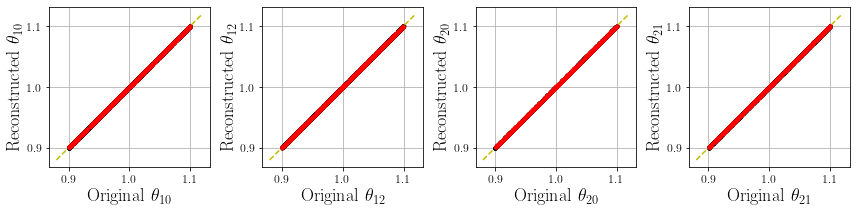

In [16]:
fig3 = plt.figure(figsize = (12, 3))
for i in range(4):
    ax = fig3.add_subplot(141 + i, aspect = "equal")
    ax.plot(rawX_train[:,i], rawX_reconstructed[:,i], "k.", zorder = 1)
    ax.plot(rawX_test[:,i], rawX_reconstructed_test[:,i], "r.", zorder = 3)
    ax.plot([0.88, 1.12], [0.88, 1.12], "y--", zorder = 2)
    ax.set_xticks(np.linspace(0.9, 1.1, 3))
    ax.set_yticks(np.linspace(0.9, 1.1, 3))
    ax.set_xlabel(r"Original " + input_names[i])
    ax.set_ylabel(r"Reconstructed " + input_names[i])
    ax.grid(True)
plt.tight_layout()

In [17]:
train_summary = np.c_[
    rawX_train,
    rawY_train,
    raw_phi_train,
    raw_beta_train,
    tensor2array(conformal_coordinates),
    rawX_reconstructed,
    rawY_predicted,
    np.zeros(rawX_train.shape[0])
]

test_summary = np.c_[
    rawX_test,
    rawY_test,
    raw_phi_test,
    raw_beta_test,
    tensor2array(conformal_coordinates_test),
    rawX_reconstructed_test,
    rawY_predicted_test,
    np.ones(rawX_test.shape[0])
]

column_names = ["q" + "".join([c for c in n if c in "012"]) for n in input_names] + \
               [("y%d" % (i+1,)) for i in range(rawY_train.shape[1])] + \
               [("p%d" % (i+1,)) for i in phi_idx] + \
               [("b%d" % (i+1,)) for i in range(raw_beta_train.shape[1])] + \
               [("c%d" % (i+1,)) for i in range(conformal_coordinates.shape[1])] + \
               ["q" + "".join([c for c in n if c in "012"]) + "_hat" for n in input_names] + \
               [("y%d_hat" % (i+1,)) for i in range(rawY_predicted.shape[1])] + \
               ["is_test"]

df = pd.DataFrame(
    data = np.r_[train_summary, test_summary],
    columns = column_names
)
df.to_excel("Conformal_Autoencoder.xlsx", index = False)

In [18]:
# if not load_weights:
#     torch.save(encoder.state_dict(), "encoder.pt")
#     torch.save(decoder.state_dict(), "decoder.pt")
#     torch.save(predictor.state_dict(), "predictor.pt")
#     if estimator is not None:
#         torch.save(estimator.state_dict(), "estimator.pt")

In [19]:
if not load_weights:
    model_dict = {
        "epoch": epoch,
        "encoder_state_dict": encoder.state_dict(),
        "encoding_optimizer_state_dict": encoding_optimizer.state_dict(),
        "encoding_scheduler": encoding_scheduler,
        "decoder_state_dict": decoder.state_dict(),
        "decoding_optimizer_state_dict": decoding_optimizer.state_dict(),
        "decoding_scheduler": decoding_scheduler,
        "predictor_state_dict": predictor.state_dict(),
        "prediction_optimizer_state_dict": prediction_optimizer.state_dict(),
        "prediction_scheduler": prediction_scheduler,
        "conformality_loss": conformality_loss,
        "prediction_loss": prediction_loss
    }

    if estimator is not None:
        model_dict["estimator_state_dict"] = estimator.state_dict()
        model_dict["estimation_state_dict"] = estimation_optimizer.state_dict()
        model_dict["estimation_scheduler"] = estimation_scheduler
    else:
        model_dict["estimator_state_dict"] = None
        model_dict["estimation_state_dict"] = None
        model_dict["estimation_scheduler"] = None

    torch.save(model_dict, "conformal_autoencoder.pt")

In [20]:
end_time = datetime.now()
print(end_time)
print(end_time - start_time)

2022-08-02 11:43:50.269983
0:00:05.789344
